*Odkomentuj i wykonaj ten kod, jeżeli masz problemy z zaimportowaniem bibliotek.*

In [1]:
# !pip install numpy==1.24.2
# !pip install seaborn==0.12.2
# !pip install pandas==1.5.3
# !pip install scikit-learn==1.2.1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.model_selection import (
    cross_validate,
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import OneHotEncoder


np.random.seed(1)

# PoweR

# Część III: Tworzenie modeli

*Prowadzący: Antoni Zajko*

## 1. Data engineering

### 1.1 Wczytanie danych

In [3]:
df = pd.read_csv("data/data.csv", index_col=["Id"])
df.shape

(1460, 80)

Dane, na których będziemy pracować, dotyczą wyceny nieruchomości nieruchomości [\[link\]](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data).

Przykładowe cechy w tych danych zawierają takie informacje jak: klasa budynku, rok budowy, metraż itp. Na potrzeby tych warsztatów nie jest konieczna dogłębna znajomość tych danych, zwłaszcza, że zawierają 80 kolumn. Jednakże zachęcam do zapoznania się z tymi danymi, ponieważ, to jest dobry zbiór, aby na nim testować różne techniki uczenia maszynowego.

Na tych warsztatach będziemy rozważali dwa problemy - klasyfikacji i regresji:
* Pierwszy z nich będzie dotyczył klasyfikacji, czy dana nieruchomość zostanie sprzedana za 100_000$, czy nie (zmienna `y_cat`)
* Drugi będzie dotyczył bezpośredniej predykcji cen (zmienna `y`)

In [4]:
X, y = df.drop(columns=["SalePrice"]), df["SalePrice"]
y_cat = (y > 100000).astype(int)

### 1.2 Oczyszczenie danych

In [5]:
columns_with_nulls_idx = df.isna().any(axis=0)
columns_with_nulls = df.columns[columns_with_nulls_idx]
columns_with_nulls

Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

W danych występuje trochę braków. Na potrzeby naszych modeli zostanie przeprowadzona prosta imputacja polegająca na:
* Zaimputowaniu 1900 do zmiennej `GarageYrBlt`
* Dodanie nowej kategorii symbolizującej brak danych w zmiennych kategorycznych
* Zaimputowanie `0` w kolumnach numerycznych

In [6]:
categorical_columns_with_nulls = df[columns_with_nulls].select_dtypes("object").columns
numerical_columns_with_nulls = df[columns_with_nulls].select_dtypes("float64").columns

In [7]:
X["GarageYrBlt"] = X["GarageYrBlt"].fillna(1900)
X[categorical_columns_with_nulls] = X[categorical_columns_with_nulls].fillna("Missing")
X[numerical_columns_with_nulls] = X[numerical_columns_with_nulls].fillna(0)

### 1.3 Podział danych

W celu późniejszej weryfikacji modelu, należy odrzucić część danych i zachować je na później. Ten zabieg ma na celu późniejsze upewnienie się, czy model dobrze generalizuje dane tzn. czy będzie działał tak samo dobrze na danych wcześniej niewidzianych, jak na tych, na których został trenowany.

Nieakceptowalne jest, żeby metryki pomiędzy tymi próbkami się w istotny sposób różniły. Wtedy mamy tzw. przetrenowanie modelu(*overfitting*). Przetrenowanie jest jednym z podstawowych problemów uczenia maszynowego i można z nim radzić na wiele sposobów np.:
* Zdobycie większej ilości danych
* **Zmniejszenie wymiarowości poprzez wybór cech**
* Uproszczenie modelu
* **Regularyzacja modelu za pomocą doboru odpowiednich hiperparametrów**

W opozycji do przetrenowania jest niedouczenie(*undefitting*). To zjawisko występuje wtedy, gdy model nie jest w stanie wyłapać istotnych zależności w danych. Objawia się to kiepskimi wartościami miar jakości modelu.

**Podczas tego i kolejnych podziałów należy uważać na tzw. wycieki danych** [Więcej o wyciekach danych](https://machinelearningmastery.com/data-leakage-machine-learning/).

Wyciek danych w uczeniu maszynowym to sytuacja, gdy do danych treningowych przedostają się informacje zawarte w danych testowych. Może to zachodzić, np. gdy:
* Przy imputacji wyznaczy się średnią, lub inną statystykę na podstawie całych danych, a nie tylko treningowych
* Przy cechach bazujących na agregacji w czasie, brane są pod uwagę informację z całych danych, czyli również też te *z przyszłości*

Istotnym objawem wycieku danych jest na przykład odstająco duży wpływ zmiennej na predykcję. Najczęściej, to takie zmienne kreują predykcję, co się wydaje być w porządku, jednakże, po wdrożeniu na środowisko produkcyjne tzn. te, z którego korzysta użytkownik końcowy, sytuacja może być zgoła inna.

In [8]:
idx_train, idx_test = train_test_split(X.index, stratify=y_cat)

X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y[idx_train], y[idx_test]
y_cat_train, y_cat_test = y_cat[idx_train], y_cat[idx_test]

## 2. Przygotowanie modelu

Jako modelu użyjemy lasu losowego z biblioteki `scikit-learn`. W związku z tym, że to jest model drzewiasty, to jedyny preprocessing, jaki zostanie zaaplikowany, to zakodowanie zmiennych kategorycznych metodą one-hot.

In [9]:
# Utworzenie enkodera
one_hot_encoder = OneHotEncoder(
    sparse_output=False, handle_unknown="ignore"
).set_output(transform="pandas")

# Zakodowanie zmiennych kategorycznych
categorical_columns = X_train.select_dtypes("object").columns
one_hot_encoded_train = one_hot_encoder.fit_transform(X_train[categorical_columns])
one_hot_encoded_test = one_hot_encoder.transform(X_test[categorical_columns])

# Zachowanie surowych danych, ponieważ będą potrzebne na później
X_train_raw = X_train.copy()
X_test_raw = X_test.copy()


# Dodanie zakodowanych kolumn kategorycznych
# i usunięcie ich surowych wersji
X_train = X_train.drop(columns=categorical_columns)
X_train = pd.concat([X_train, one_hot_encoded_train], axis=1)
X_test = X_test.drop(columns=categorical_columns)
X_test = pd.concat([X_test, one_hot_encoded_test], axis=1)

In [10]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced", n_estimators=5, max_depth=5, random_state=1
)

In [11]:
rf_classifier.fit(X_train, y_cat_train)
print(f"{roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=}")
print(f"{roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=}")

roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=0.9033280593003599
roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=0.8717886807031099


## 1. Wybór zmiennych

Wybór zmiennych jest jedną z najważniejszych rzeczy, jakie powinny zostać wykonane podczas przygotowywania modelu, zwłaszcza jeżeli dane składają się z bardzo wielu kolumn. Potrzeba wyboru zmiennych wynika m. in. z tego, że niektóre informacje mogą być zawarte w kilku kolumnach, więc część z nich można wyrzucić (patrz`:` badanie korelacji poniżej) lub przede wszystkim zmienne mogą mieć niską predykcyjność  (patrz wybór za pomocą modelu i RFE poniżej), przez co nie wnoszą nic wartościowego do modelu oraz zmienne mogą być mocno zaszumione, przez co może dochodzić do zjawiska przetrenowania.

* Badanie korelacji
* Za pomocą modelu
* RFE

### 1.1 Badanie korelacji

Istnieje wiele typów badania wzajemnych zależności pomiędzy zmiennymi. My się zajmiemy dwoma z nich: korelacją Pearsona oraz korelacją Spearmana.

1. *Korelacja Pearsona* - jej główną zaletą jest prostota. Niestety, nadaje się tylko do znajdowania zależności liniowych pomiędzy zmiennymi, ponieważ dla nieliniowych zależności jej wartości okazują się być często relatywnie małe (Przykład 1). Wartości tego współczynnika zawierają się w przedziale $[-1, 1]$, gdzie -1 jest osiągane dla zmiennych, które są zależne od siebie liniowo z ujemnym współczynnikiem, zaś 1, dla zmiennych zależnych liniowo z dodatnim współczynnikiem. Korelacja Pearsona wyraża się wzorem:
$$\rho(X, Y) = \sum_{i=1}^n\frac{(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^n(x_i - \bar{x})^2\sum_{i=1}^n(y_i - \bar{y})^2}}$$

2. *Korelacja Spearmana* - jej ważną zaletą jest dużo większa uniwersalność. Wyłapuje wszysktie zależności monotoniczne między zmiennymi (Przykład 2), ale nie zawsze jest w stanie znaleźć niemonotoniczną zależność funkcyjną (Przykład 3). Korelacja Spearmana wyraża się wzorem:
$$\rho_s = \rho(rank(X), rank(Y))$$
gdzie $rank(X)$ przyporządkowuje dla wszystkich elementów listy ich pozycje po posortowaniu np. dla $X = (0.2, 0.53, 0.11)$, $rank(X) = (2, 3, 1)$

PearsonRResult(statistic=0.551002275743353, pvalue=0.014481599911684533)

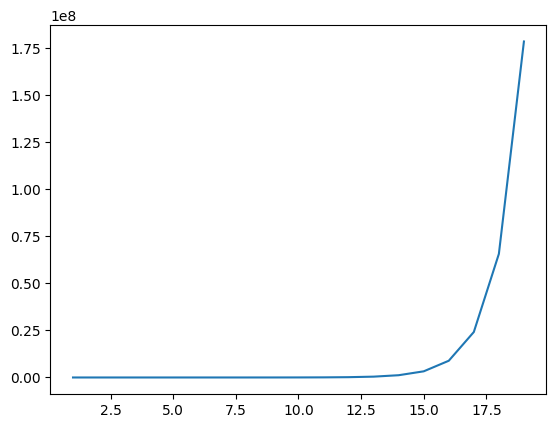

In [12]:
# Przykład 1
# Dla zmiennych zaleznych funkcyjnie od siebie wspolczynnik
# korelacji pearsona potrafi byc maly
x1 = np.array(list(range(1, 20, 1)))
x2 = np.exp(x1)
plt.plot(x1, x2)
scipy.stats.pearsonr(x1, x2)

SignificanceResult(statistic=1.0, pvalue=0.0)

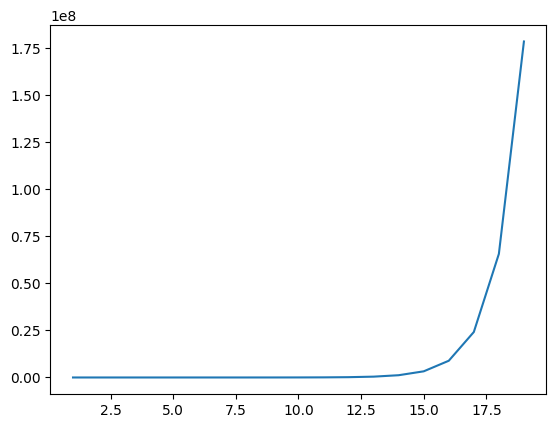

In [13]:
# Przykład 2
# Dla danych z przykładu 1 policzono korelacje Spearmana.
# Skoro to jest zależność monotoniczna, to ta korelacja jest wysoka
x1 = np.array(list(range(1, 20, 1)))
x2 = np.exp(x1)
plt.plot(x1, x2)
scipy.stats.spearmanr(x1, x2)

SignificanceResult(statistic=-0.038033395176252316, pvalue=0.7085853580142755)

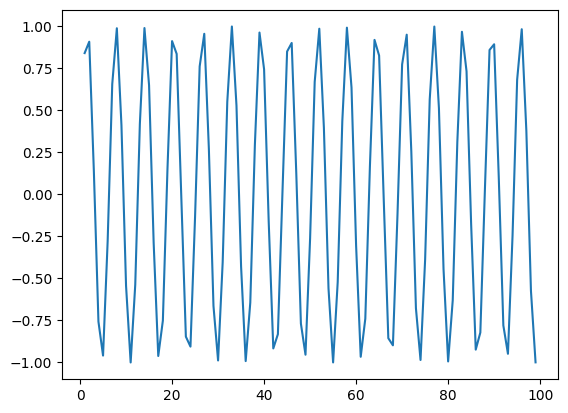

In [14]:
# Przykład 3
# Korelacja Spearmana nie zawsze sobie radzi z niemonotonicznymi zależnościami między zmiennymi
x1 = np.array(list(range(1, 100, 1)))
x2 = np.sin(x1)
plt.plot(x1, x2)
scipy.stats.spearmanr(x1, x2)

Zbadajmy macierz korelacji w naszych danych (**Uwaga:** badamy to dla danych treningowych w celu uniknięcia przecieku)

/tmp/ipykernel_70361/1158790349.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = X_train_raw.corr("spearman")


<Axes: >

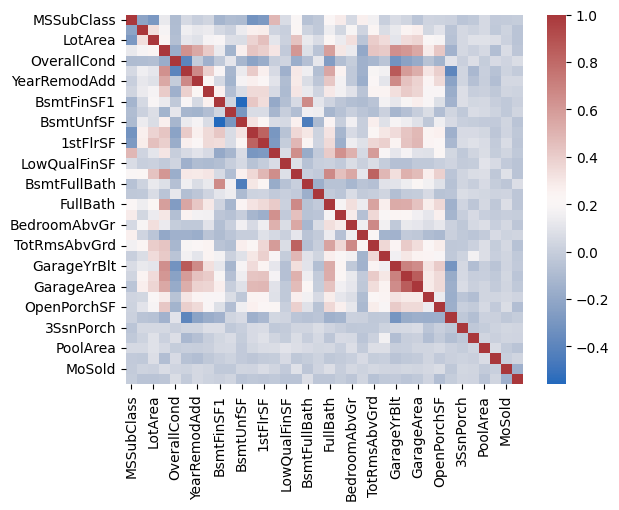

In [15]:
import seaborn as sns

corr_mat = X_train_raw.corr("spearman")
sns.heatmap(corr_mat, cmap="vlag")

<Axes: >

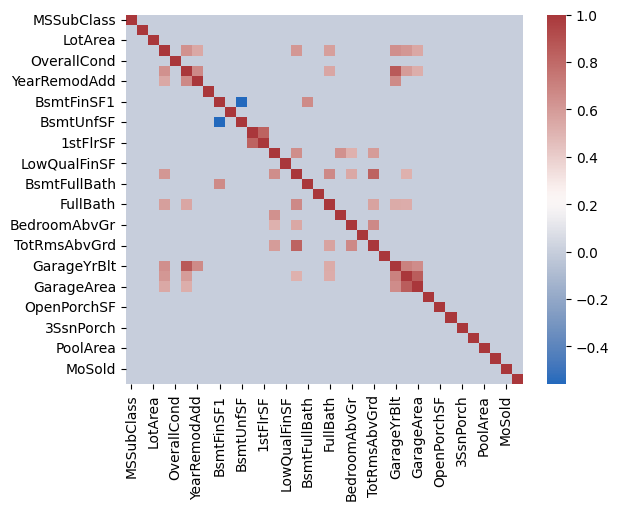

In [16]:
corr_mat[np.abs(corr_mat) < 0.5] = 0
sns.heatmap(corr_mat, cmap="vlag")

Rozważmy zmienne `1stFlrSF` i `GarageArea`

In [17]:
scipy.stats.spearmanr(X_train["1stFlrSF"], X_train["GarageArea"])

SignificanceResult(statistic=0.4833641085718706, pvalue=3.4612982048896514e-65)

Dopasujmy do naszych danych docelowy model

In [18]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced", n_estimators=10, max_depth=2, random_state=1
)
rf_classifier.fit(X_train, y_cat_train)

print(f"{roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=}")
print(f"{roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=}")

roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=0.8440547921453032
roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=0.870436546262314


Ważne jest, że model nie jest przetrenowany. Przetrenowany model byłby bezwartościowy w kontekście dalszych rozważań.

In [19]:
# Od teraz używamy właściwego modelu
feature_names = rf_classifier.feature_names_in_
feature_importance_values = rf_classifier.feature_importances_

In [20]:
# Istotność cechy 1stFlrSF
feature_importance_values[np.where(feature_names == "1stFlrSF")]

array([0.])

In [21]:
# Istotność cechy GarageArea
feature_importance_values[np.where(feature_names == "GarageArea")]

array([0.13027548])

Z tego wynika, że można odrzucić zmienną `1stFlrSF` na rzecz `GarageArea`. My tego teraz nie zrobimy, ponieważ będziemy chcieli przeprowadzać podobny proces automatycznie. Jednakże, kiedy mamy dużo głębsze zrozumienie danych, oraz relatywnie niewiele kolumn, to ten sposób jest najlepszy na selekcje zmiennych.

## Zadanie

Zauważ, że `GarageArea` i `LotArea` są ze sobą skorelowane. Przeprowadź powyższe rozumowanie dla tych zmiennych. Czy biorąc pod uwagę znaczenie tych zmiennych jest sens odrzucać którąś z nich?

In [22]:
scipy.stats.spearmanr(df["GarageArea"], df["YearBuilt"])

SignificanceResult(statistic=0.5282813479249705, pvalue=9.897241089259135e-106)

In [23]:
# Miejsce na twój kod

### 1.1 Wybór zmiennych za pomocą istotności zmiennych w modelu

Alternatywą dla powyższego rozumowania jest badanie istotności zmiennych za pomocą zbadania prostego (a nawet naszego docelowego) modelu. Modele z reguły mają miary tego, jak poszczególne zmienne są ważne przy prognozowaniu zmiennej celu np.:
* Redukcja funkcji straty w modelach drzewiastych [\[1\]](https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8) [\[2\]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier) 
* Współczynniki przy modelu regresji logistycznej
* Metody niezależne od modelu (model-agnostic) np. SHAP, PDP [\[3\]](https://ema.drwhy.ai/)

W naszym przykładzie użyjemy docelowego modelu lasu losowego wraz z jego natywną metryką istotności zmiennych i na podstawie tego weźmiemy tylko wąski podzbiór zmiennych potrzebnych do prognozowania. 

In [24]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced", n_estimators=10, max_depth=2, random_state=1
)

In [25]:
rf_classifier.fit(X_train, y_cat_train)
print(f"{roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=}")
print(f"{roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=}")

roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=0.8440547921453032
roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=0.870436546262314


Model nie jest przetrenowany, więc nadaje się do dalszego rozumowania

In [26]:
features = rf_classifier.feature_names_in_
features_vals = rf_classifier.feature_importances_.reshape(-1)

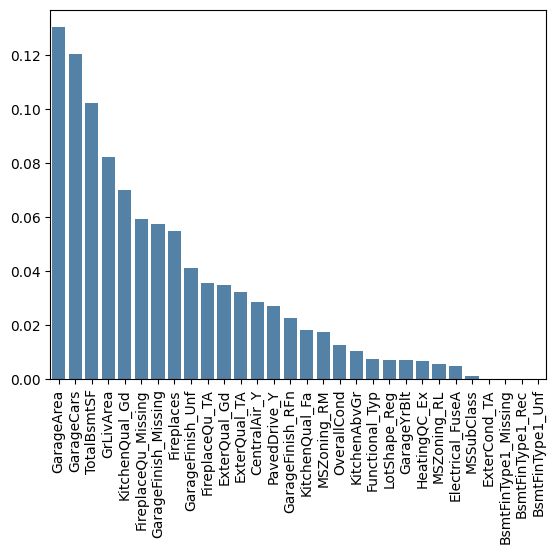

In [27]:
idx = np.argsort(-features_vals)[0:30]
sns.barplot(x=features[idx], y=features_vals[idx], color="steelblue")
plt.xticks(rotation=90)
plt.show()

Można zauważyć, że zmienne na prawo od `Electrical_FuseA` mają istotność bliską 0, zatem wybierzmy wszystkie zmienne do `Electrical_FuseA` włącznie tj. pierwsze 25 zmiennych

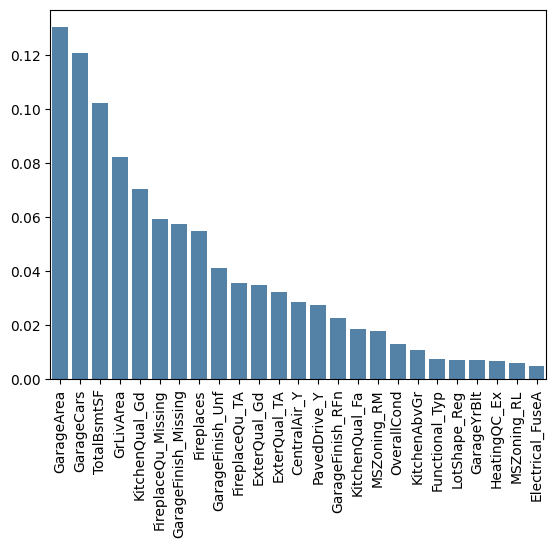

In [28]:
idx = np.argsort(-features_vals)[0:25]
sns.barplot(x=features[idx], y=features_vals[idx], color="steelblue")
plt.xticks(rotation=90)
plt.show()

Wybierzmy ustalone przez nas cechy

In [29]:
selected_features = rf_classifier.feature_names_in_[np.argsort(-features_vals)[0:25]]

In [30]:
X_train_feature_selected = X_train[selected_features]
X_test_feature_selected = X_test[selected_features]

In [31]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced", n_estimators=10, max_depth=2, random_state=1
)
rf_classifier.fit(X_train, y_cat_train)
print(f"{roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=}")
print(f"{roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=}")

roc_auc_score(y_cat_train, rf_classifier.predict(X_train))=0.8440547921453032
roc_auc_score(y_cat_test, rf_classifier.predict(X_test))=0.870436546262314


Zauważmy, że jakość modelu nie pogorszyła się, pomimo faktu, że wzięliśmy tylko jedną czwartą pierwotnych zmiennych

## 1.2 RFE (Recursive Feature Elimination)

Powyższą metodę można zautomatyzować w następujący sposób:

```
Dopóki w danych jest więcej niż n zmiennych:
    1. Trenuj na nich model uczenia maszynowego (najlepiej prosty i dobrze interpretowalny).
    2. Odrzuć k najmniej istotnych cech
```
Powyższy algorytm nazywa się RFE (Recursive Feature Elimination) [Link do artykułu](https://machinelearningmastery.com/rfe-feature-selection-in-python/).

In [32]:
%%capture

rfe = RFE(
    estimator=RandomForestClassifier(class_weight="balanced", n_estimators=10, max_depth=2, random_state=1),
    n_features_to_select=20, 
    step=5
).set_output(transform="pandas")
rfe.fit(X_train, y_cat_train)

In [33]:
X_train_feature_selected_2 = rfe.transform(X_train)
X_test_feature_selected_2 = rfe.transform(X_test)

In [34]:
rf_classifier = RandomForestClassifier(
    class_weight="balanced", n_estimators=5, max_depth=3, random_state=1
)
rf_classifier.fit(X_train_feature_selected_2, y_cat_train)

print(
    f"{roc_auc_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2))=}"
)
print(f"{roc_auc_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2))=}")

roc_auc_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2))=0.8590099267415146
roc_auc_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2))=0.8295344794282404


In [35]:
X_train_feature_selected.columns

Index(['GarageArea', 'GarageCars', 'TotalBsmtSF', 'GrLivArea',
       'KitchenQual_Gd', 'FireplaceQu_Missing', 'GarageFinish_Missing',
       'Fireplaces', 'GarageFinish_Unf', 'FireplaceQu_TA', 'ExterQual_Gd',
       'ExterQual_TA', 'CentralAir_Y', 'PavedDrive_Y', 'GarageFinish_RFn',
       'KitchenQual_Fa', 'MSZoning_RM', 'OverallCond', 'KitchenAbvGr',
       'Functional_Typ', 'LotShape_Reg', 'GarageYrBlt', 'HeatingQC_Ex',
       'MSZoning_RL', 'Electrical_FuseA'],
      dtype='object')

In [36]:
X_train_feature_selected_2.columns

Index(['2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       '3SsnPorch', 'MoSold', 'MSZoning_RL', 'SaleCondition_Abnorml',
       'SaleCondition_AdjLand'],
      dtype='object')

In [37]:
set(X_train_feature_selected.columns).intersection(
    set(X_train_feature_selected_2.columns)
)

{'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenAbvGr',
 'MSZoning_RL'}

## 2. Metryki

### 2.1 Klasyfikacja

#### Słowniczek
* **$TP$** (True positive) - liczba poprawnych klasyfikacji obserwacji z klasy 1
* **$FP$** (False positive) - liczba poprawnych klasyfikacji obserwacji jako 1, gdzie w rzeczywistości jest w klasie 0
* **$TN$** (True negative) - liczba poprawnych klasyfikacji obserwacji z klasy 0
* **$FN$** (False negative) - liczba poprawnych klasyfikacji obserwacji jako 0, gdzie w rzeczywistości jest w klasie 1

Wówczas:
1. $TP$ + $FP$ + $TN$ + $FN$ - liczba wszystkich obserwacji
2. $TP$ + $FP$ - liczba obserwacji zaklasyfikowanych jako 1
3. $TP$ + $FN$ - rzeczywista liczba obserwacji w klasie 0
4. $\dots$

### 2.1.1 Accuracy
Po polsku zwana dokładnością. Mówi, jaki procent predykcji modelu okazał się trafiony. Najbardziej intuicyjna metryka, jednakże posiada bardzo poważne wady. Jej największą wadą jest niewiarygodność na zbiorach niezbalansowanych tzn. w takich, gdzie jest znacząca przewaga jednej z klas zmiennej celu. Przypuśćmy, że w zbiorze danych jest 90% przykładów negatywnych (0) i 10% przykładów pozytywnych (1), wówczas "model", który przewiduje zawsze 0, będzie miał 0,9 accuracy, co się wydaje być dobrym wynikiem. Wyraża się wzorem:
$$\frac{TP + FP}{TP + FP + TN + FN}$$

In [38]:
print(
    f"Train accuracy: {accuracy_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2)):.2f}"
)
print(
    f"Test accuracy: {accuracy_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2)):.2f}"
)

Train accuracy: 0.85
Test accuracy: 0.82


### 2.1.2 Recall
Po polsku zwany czułością. Mówi, jaki procent wszystkich przykładów z klasy mniejszości (1), udało się wykryć modelowi. Podstawowa metryka przy wykrywaniu anomalii, gdzie jest dużo większy koszt niewykrycia, niż wywołanie "fałszywego alarmu" np. w medycynie. Wyraża się wzrorem:
$$\frac{TP}{TP + FN}$$

In [39]:
print(
    f"Train recall: {recall_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2)):.2f}"
)
print(
    f"Test recall: {recall_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2)):.2f}"
)

Train recall: 0.85
Test recall: 0.82


### 2.1.3 Precision
Po polsku zwana precyzją. Mówi, jaki procent wszystkich predykcji modelu na 1 okazała się być trafiona. Przydatna w sytuacji, gdy niewykrycie anomalii itp. jest mniej kosztowne, niż fałszywe "wykrycie". Stoi w opozycji do czułości, ponieważ, gdy precyzja rośnie, to czułość maleje i vice versa. Wyraża się wzorem:
$$\frac{TP}{TP + FP}$$

In [40]:
print(
    f"Train precision: {precision_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2)):.2f}"
)
print(
    f"Test precision: {precision_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2)):.2f}"
)

Train precision: 0.99
Test precision: 0.98


**Dygresja**: Modele klasyfikacyjne najczęściej zwracają prawdopodobieństwa. W związku z tym, precyzją i czułością można łatwo manipulować przy użyciu wartości progowej (threshold), powyżej której stwierdzamy, że dana obserwacja należy do klasy 1.

### 2.1.4 F1 score

W sytuacji, gdy zależy nam zarówno na precyzji, jak i czułości, możemy użyć metryki *F1 score*. Jest to średnia harmoniczna z precyzji i czułości:
$$2\frac{precision*recall}{precision + recall} = \frac{2TP}{2TP + FP + FN}$$

In [41]:
print(
    f"Train F1: {f1_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2)):.2f}"
)
print(
    f"Test F1: {f1_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2)):.2f}"
)

Train F1: 0.91
Test F1: 0.89


### 2.1.5 Krzywa ROC (Receiver Operating Curve)

Jedną z istotnych wad poprzednich metryk, jest to, że ściśle zależą od wartości progowej, powyżej której prawdopodobieństwo oznacza, że dana obserwacja należy do klasy 1. W związku z tym warto użyć krzywej ROC, która bada zachowanie modelu całościowo, na wszystkich progach. Na osi x ta krzywa ma frakcję $\frac{FP}{TP + FP}$, a na osi y $\frac{TP}{TP + FP}$. W związku z tym im "wyżej" się ta krzywa znajduje, tym lepiej.

In [42]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(
    y_cat_test, rf_classifier.predict_proba(X_test_feature_selected_2)[:, 1]
)

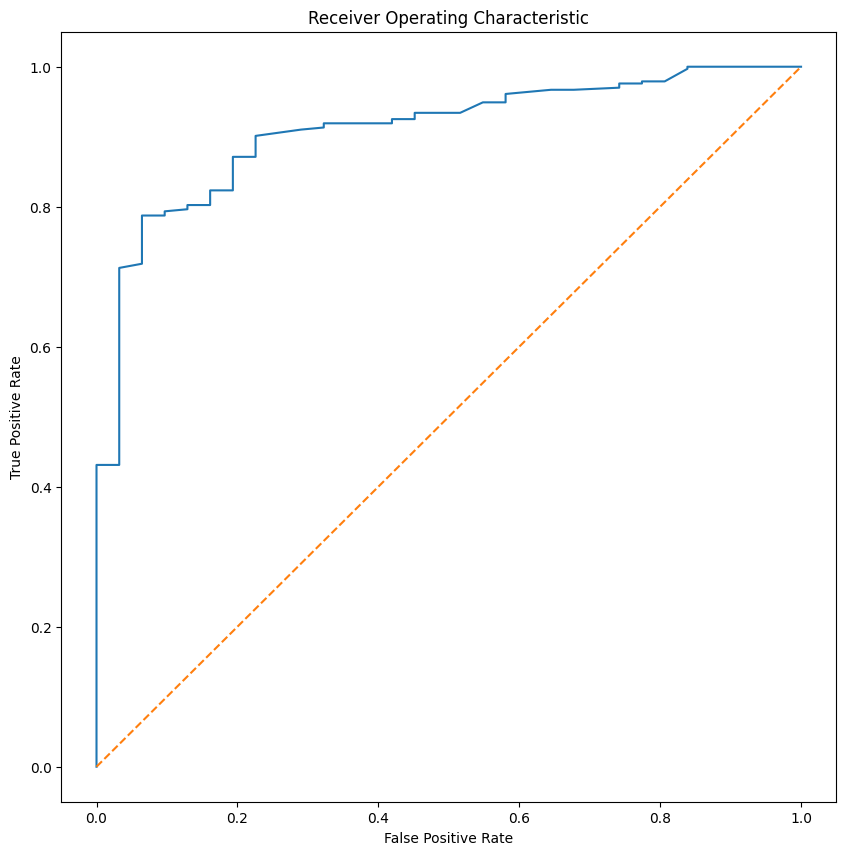

In [43]:
plt.subplots(1, figsize=(10, 10))
plt.title("Receiver Operating Characteristic")
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

### 2.1.6 ROC AUC

Dobrą miarą tego, jak wysoko jest ta krzywa jest pole pod nią (Area Under Curve). Ta metryka dobrze pokazuje ogólny performance modelu na wszystkich progach razem wziętych i jest bardzo często, choć nie zawsze uznawana za jedną z najlepszych metryk jakości modelu.

In [44]:
print(
    f"{roc_auc_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2))=}"
)
print(f"{roc_auc_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2))=}")

roc_auc_score(y_cat_train, rf_classifier.predict(X_train_feature_selected_2))=0.8590099267415146
roc_auc_score(y_cat_test, rf_classifier.predict(X_test_feature_selected_2))=0.8295344794282404


### 2.2 Regresja

Przejdźmy na chwilę do problemu regresji. Dopasujemy prosty las losowy w celu przedstawienia trzech podstawowych metryk modeli rozwiązujących problemy tej klasy.

In [45]:
rf_regressor = RandomForestRegressor(n_estimators=5, max_depth=3, random_state=1)
rf_regressor.fit(X_train_feature_selected_2, y_train)

RandomForestRegressor(max_depth=3, n_estimators=5, random_state=1)

### 2.2.1 MSE

**MSE** (Mean Squared Error - Błąd średniokwadratowy) jest to miara tego jak daleko znajdują się predykcje od rzeczywistych wartości. W związku z tym, że cały błąd jest sumą kwadratów odległości predykcji od prawdziwych wartości, może być ciężko go interpretować. Pomimo tego, jest to fundamentalna metryka w regresji, ponieważ ma wiele korzystnych wartości m. in. jest wypukła i różniczkowalna, czego nie można powiedzieć o np. MAE (dalej). MSE wyraża się wzorem:
$$MSE = \frac{1}{n}\sum_{i=0}^{n}(\hat{y_i} - y_i)^2$$ 

In [46]:
print(
    f"Train mse: {mean_squared_error(rf_regressor.predict(X_train_feature_selected_2), y_train):.2f}"
)
print(
    f"Test mse: {mean_squared_error(rf_regressor.predict(X_test_feature_selected_2), y_test):.2f}"
)

Train mse: 1801274623.59
Test mse: 2766554357.28


### 2.8 MAE

Drugą, nieco bardziej interpretowalną metryką jest **MAE** (Mean Absolute Error). Jest to suma modułów różnic predykcji i rzeczywistych wartości zmiennych celu. Wyraża się wzorem:
$$MAE = \frac{1}{n}\sum_{i=0}^{n}|\hat{y_i} - y_i|$$ 

In [47]:
print(
    f"Train mae: {mean_absolute_error(rf_regressor.predict(X_train_feature_selected_2), y_train):.2f}"
)
print(
    f"Test mae: {mean_absolute_error(rf_regressor.predict(X_test_feature_selected_2), y_test):.2f}"
)

Train mae: 30076.40
Test mae: 34808.68


### 2.9 $R^2$

Powyższe metryki dobrze opisują, jak bardzo nasz model się myli. Jednakże nie pokazują, ile wariancji wyjaśniamy naszym modelem. W związku z tym, można w tym celu użyć $R^2$ (Współczynnika determinacji). Wyraża się wzorem:
$$R^2=1 - \frac{\sum(y_i - \hat{y_i})^2}{\sum(y_i - \bar{y_i})^2}$$

In [48]:
print(
    f"Train r2: {r2_score(rf_regressor.predict(X_train_feature_selected_2), y_train):.2f}"
)
print(
    f"Test r2: {r2_score(rf_regressor.predict(X_test_feature_selected_2), y_test):.2f}"
)

Train r2: 0.55
Test r2: 0.38


### Zadanie
Poniżej jest podany model regresji logistycznej, który jest modelem klasyfikacyjnym. Wyznacz dla niego wszystkie metryki. Co powiedzieć o tym modelu? Czy jest przetrenowany? Czy jeżeli założymy, że false positive kosztuje więcej, niż false negative, to model jest dobry?

In [49]:
logistic_classifier = LogisticRegression(penalty="l1", C=1e-4, solver="saga")
logistic_classifier.fit(X_train_feature_selected_2, y_cat_train)

LogisticRegression(C=0.0001, penalty='l1', solver='saga')

In [50]:
# Miejsce na twój kod

## 3. Kroswalidacja

W celu sprawdzenia jakości wytrenowanego modelu, musimy porównać, to jak sobie radzi na próbce, na której został wytrenowany oraz na danych, których wcześniej nie widział. Jednakże, jeżeli to sprawdzimy dla jednego takiego podziału na próby testowe i treningowe, to nasze wnioski mogą być obciążone wieloma czynnikami np. tym, że model tylko dla tego jednego podziału działał dobrze. W związku z tym takie porównanie można wykonać kilka razy dzieląc dane na kilka różnych sposobów i wtedy zbiorczo podsumować wyniki, co może bardziej uwiarygodnić metryki modelu. Dodatkowo, mając kilka wartości danej metryki, można na podstawie wariancji tych metryk wyciągnać dodatkowe wnioski na temat jakości tego modelu np. czy się nie przetrenowuje, oraz jak bardzo wiarygodne są wyniki przeprowadzonej przed chwilą kroswalidacji. Poniżej wizualizacja tej metody:

![img](img/cv.jpg)

Istotnym czynnikiem przy dzieleniu i przygotowywaniu danych przy kroswalidacji jest unikanie przecieków danych, bo w przeciwnym przypadku możemy otrzymać zbyt optymistyczne wyniki np.:
* Jeżeli standaryzujemy dane to należy to robić tylko na podstawie danych *treningowych* bez walidacyjnych
* W danych będących szeregiem czasowym, próbka walidacyjna powinna być w jednym spójnym interwale czasowym
* W danych dot. wzorców behawioralnych klienta, wszystkie rekordy dot. danego klienta powinny być w jednej próbce
* Jeżeli agregujemy dane, to nie mogą one zawierać danych z przyszłości
* $\dots$

[Link do różnych sposobów podziału danych przy kroswalidacji w bibliotece scikit-learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators)

In [51]:
mod = RandomForestClassifier(
    class_weight="balanced", n_estimators=10, max_depth=2, random_state=1
)
mod.fit(X_train_feature_selected_2, y_cat_train)
cross_validate(
    mod,
    X_train_feature_selected_2,
    y_cat_train,
    scoring="roc_auc",
    return_train_score=True,
)

{'fit_time': array([0.03165054, 0.02867341, 0.02352548, 0.02274203, 0.02415085]),
 'score_time': array([0.00699043, 0.0060482 , 0.00517726, 0.00488472, 0.00458765]),
 'test_score': array([0.87078496, 0.86663903, 0.90201769, 0.87105263, 0.91723684]),
 'train_score': array([0.91174934, 0.90709038, 0.90698086, 0.91444753, 0.90575581])}

In [52]:
mod = RandomForestClassifier(
    class_weight="balanced", n_estimators=5, max_depth=3, random_state=1
)
mod.fit(X_train_feature_selected_2, y_cat_train)
cross_validate(
    mod,
    X_train_feature_selected_2,
    y_cat_train,
    scoring="roc_auc",
    return_train_score=True,
    cv=StratifiedKFold(shuffle=True),
)

{'fit_time': array([0.01585603, 0.01532722, 0.01493955, 0.01518106, 0.01423883]),
 'score_time': array([0.00578618, 0.00447011, 0.00456262, 0.00411582, 0.00457025]),
 'test_score': array([0.88211719, 0.90851299, 0.86967938, 0.90921053, 0.92039474]),
 'train_score': array([0.93031779, 0.93897014, 0.92837164, 0.93760555, 0.93975503])}

## 4. Optymalizacja hiperparametrów

Nie wszystkie parametry modelu da się wytrenować. Niektóre z nich ustalają kształt całego modelu, lub jego strategię trenowania. W związku z tym te parametry muszą zostać dobrane przez osobę, która tworzy dany model. Można tego dokonać na różne sposoby m. in.:
* Dobór na podstawie wiedzy dziedzinowej i własnych doświadczeń
* Dobór na podstawie powszechnych heurystyk i założeń dot. danego modelu
* Dobór metodą prób i błędów

My się zajmiemy tą ostatnią strategią i pokażemy jak to można zautomatyzować. Jednymi z najpopularniejszych strategii automatycznego doboru hiperparametrów są:
* **Grid search** - specyfikujemy siatkę hiperparametrów i przechodzimy przez wszystkie możliwe ich kombinacje. Zaletą tego rozwiązania jest fakt, że napewno znajdzie najlepszą kombinację, natomiast wadą, bardzo duże zużycie zasobów, ponieważ algorytm muśi wytrenować modele dla wszystkich możliwych kombinacji hiperparametrów
* **Random search** - spośród wskazanej siatki hiperparametrów losujemy ustaloną liczbę kombinacji modelu i dla nich sprawdzamy scoring i wybieramy najlepszy. Zaletą tego rozwiązania jest wydajność, natomiast wadą to, że zazwyczaj nie znajdziemy najlepsza kombinację.
* **Optymalizacja oparta na algorytmach optymalizujących funkcje będącą "czarną skrzynką"** - podejście traktujące problem optymalizacji jak optymalizację pewnej funkcji. Traktujemy siatkę hiperparametrów jak dziedzinę funkcji i algorytmem znajdujemy jej minimum/maksimum. Zaletą tego rozwiązania jest wydajność, ponieważ przeszukujemy tylko pewną część przestrzeni hiperparametrów, natomiast wadą jest to, że nie zawsze znajdziemy najlepszą kombinację, jednakże te algorytmy są na tyle dobre, że bardzo często otrzymuje się wyniki, zbliżone do najlepszych [Przykładowa biblioteka, która to realizuje](https://optuna.org/).

Najczęściej w parze z optymalizacją hiperparametrów idzie również kroswalidacja, ponieważ pomimo dodatkowego narzutu obliczeniowego, dostajemy dużo bardziej wiarygodne wyniki oraz dokładniej możemy sprawdzić, czy model się przetrenowuje.

### 2.1 Grid search

In [53]:
grid_search = GridSearchCV(
    RandomForestClassifier(
        class_weight="balanced", n_estimators=5, max_depth=3, random_state=1
    ),
    {
        "n_estimators": list(range(5, 50, 5)),
        "max_depth": list(range(1, 5)),
        "max_leaf_nodes": list(range(2, 5)),
    },
    scoring="roc_auc",
)
grid_search.fit(X_train_feature_selected_2, y_cat_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              max_depth=3, n_estimators=5,
                                              random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4], 'max_leaf_nodes': [2, 3, 4],
                         'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45]},
             scoring='roc_auc')

In [54]:
grid_search.best_score_

0.907938305548282

In [55]:
rf_classifier = grid_search.best_estimator_
rf_classifier.fit(X_train_feature_selected_2, y_cat_train)
cross_validate(
    rf_classifier,
    X_train_feature_selected_2,
    y_cat_train,
    scoring="roc_auc",
    return_train_score=True,
)

{'fit_time': array([0.12550044, 0.09867239, 0.11188579, 0.08912396, 0.11063981]),
 'score_time': array([0.00960493, 0.01093102, 0.00976491, 0.00931978, 0.01080799]),
 'test_score': array([0.90713101, 0.89883914, 0.92385296, 0.88013158, 0.92973684]),
 'train_score': array([0.9312698 , 0.93015771, 0.92756285, 0.92947679, 0.93167744])}

### 2.2 Random search

### Zadanie
W bibliotece `scikit-learn` znajduje się klasa realizująca random seach - `RandomizedSearchCV`. Zaimportuj tą klasę z pakietu `sklearn.model_selection` i za jej pomocą zoptymalizuj hiperparametry dla modelu `mod`. Robi się to w analogiczny sposób do `GridSearchCV` z tą różnicą, że przy tworzeniu obiektu podaje się parametr `n_iter`, który steruje ilością przeszukanych modeli.

In [56]:
mod = RandomForestClassifier(class_weight="balanced")

In [57]:
from sklearn.model_selection import RandomizedSearchCV

# Miejsce na kod